In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from enterprise.signals.utils import powerlaw

from la_forge.core import Core

import sys
sys.path.append('../')
sys.path.append('../../PerFreqOS')

from defiant import OptimalStatistic
from defiant import utils,pair_covariance
from defiant.extra import mdc1_utils

In [8]:
psrs,inj_params = mdc1_utils.get_mdc1_psrs()

pta = mdc1_utils.create_MDC1_PTA(psrs)

OS_obj = OptimalStatistic(psrs,pta=pta,gwb_name='gw',core_path='MDC1_FG_CURN_samples.core',
                          orfs=['hd','dipole','monopole'])

Loading data from HDF5 file....


### Next, we need to set it as a MCOS and get all of the elements of the MCOS

In [9]:
X,Z = OS_obj._compute_XZ(inj_params)
gw_signal = [s for s in OS_obj.pta._signalcollections[0] if s.signal_id==OS_obj.gwb_name][0]
phi = gw_signal.get_phi(inj_params)
rhok,sigk,normk = OS_obj._compute_rhok_sigk(X,Z,phi,False)
xi,_ = utils.compute_pulsar_pair_separations(OS_obj.psrs, OS_obj._pair_idx)


problem_freq = 4
ORF = OS_obj._orf_matrix
design = OS_obj.orf_design_matrix

Sk = phi[problem_freq*2]

phi1 = np.zeros( shape=(len(OS_obj.freqs)) )  
phi1[problem_freq] = 1
phi1 = np.repeat(phi1,2)

phi2 = phi/Sk

### In order to get the covariance matrix, we need to assume things, so lets define a function so we can change it

In [10]:
def compute_mcos_pair_covariance(Z, phi1, phi2, orf, design, 
                                  rho_ab, sig_ab, norm_ab, a2_est,
                                  use_tqdm, max_chunk):

    fact_c = pair_covariance._factored_pair_covariance(Z,phi1,phi2,orf[0],norm_ab,use_tqdm,max_chunk)
    return np.array(( fact_c[0], a2_est*fact_c[1] + a2_est**2*fact_c[2] ))


In [12]:
C = compute_mcos_pair_covariance(Z, phi1, phi2, ORF, design, rhok[problem_freq], 
                             sigk[problem_freq], normk[problem_freq], Sk, True, 300)
Ck = C[0] + C[1]
A2,A2s = utils.linear_solve(design,C,rhok[problem_freq],'woodbury')
print(A2,A2s)

PC elements: 199500it [00:00, 529837.01it/s]                                    


[-6.30095751e-16  1.00137414e-16 -8.77414400e-17] [[ 1.26205891e-29 -4.71368355e-31 -2.96147416e-31]
 [-4.71368355e-31  4.67759354e-31  8.12063012e-33]
 [-2.96147416e-31  8.12063012e-33  2.08950542e-31]]


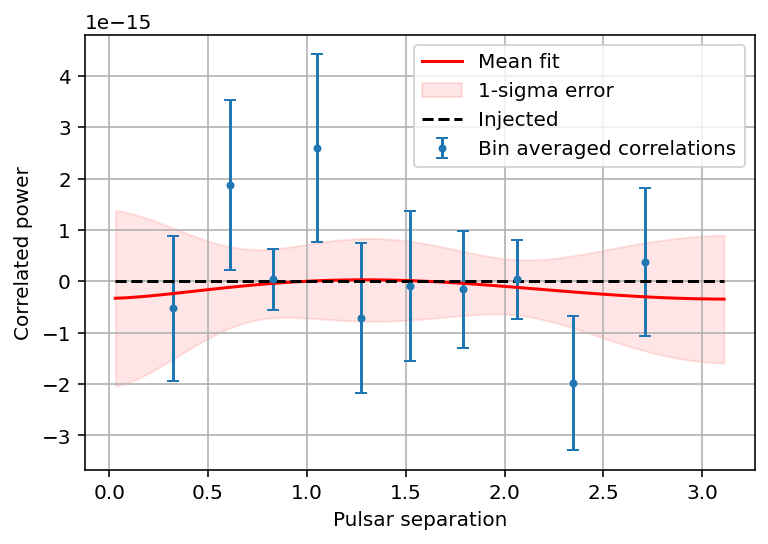

In [13]:
xi_range = np.linspace(0,np.pi,102)[1:-1]
hd_mod = utils.orf_xi(xi_range,'hd')

xiBin,rhoBin,sigBin = utils.binned_pair_correlations(xi,rhok[problem_freq],Ck,bins=10)
plt.errorbar(xiBin,rhoBin,sigBin,fmt='.',capsize=3,label='Bin averaged correlations')
cor_mean,cor_sig = utils.calculate_mean_sigma_for_MCOS(xi_range,A2,A2s,['hd','dipole','monopole'])
plt.plot(xi_range,cor_mean,'-r',label='Mean fit')
plt.fill_between(xi_range,(cor_mean-cor_sig),(cor_mean+cor_sig),color='r',alpha=0.1,label='1-sigma error')

plt.plot(xi_range,10**(2*inj_params['gw_log10_A'])*hd_mod,'--k',label='Injected')

plt.xlabel('Pulsar separation')
plt.ylabel('Correlated power')
plt.grid()
plt.legend()
plt.show()